# Task 2

## Packages and Data

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import plotly.io as pio

In [2]:
wea_geo = pd.read_csv('../Data/Wetterdaten_Custom/wea_geo.csv')
sales = pd.read_csv('../Data/Umsatzdaten/processed_umsatz.csv')

wea_geo['MESS_DATUM'] = pd.to_datetime(wea_geo['MESS_DATUM'])

sales['Datum'] = pd.to_datetime(sales['Datum']).dt.normalize()

# Weather data from 1994 onwards
wea_geo = wea_geo[wea_geo['MESS_DATUM'] >= '1994']

# Sales only from camping pitches
sales_camping = sales[sales['Gastgewerbe'] == 'WZ08-553'] 

## a. Correlation between ⌀-temperature and sales

### Preprocessing

In [3]:
# Average temperature per Month and per Station 
avg_temp_per_station = wea_geo.groupby(['Stations_id', pd.Grouper(key='MESS_DATUM', freq='M')])['TMK'].mean()
avg_temp_per_station = avg_temp_per_station.reset_index()

avg_temp_per_station['year_month'] = avg_temp_per_station['MESS_DATUM'].dt.to_period('M')
avg_temp_per_station.head(3)

C:\Users\Ready2Go\AppData\Local\Temp\ipykernel_4340\2037697186.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  avg_temp_per_station = wea_geo.groupby(['Stations_id', pd.Grouper(key='MESS_DATUM', freq='M')])['TMK'].mean()


,Stations_id,MESS_DATUM,TMK,year_month
0,377,1994-01-31,3.845161,1994-01
1,377,1994-02-28,2.285714,1994-02
2,377,1994-03-31,8.703226,1994-03


In [4]:
# Average temperature per Month
avg_temp = avg_temp_per_station.groupby('year_month').mean()
avg_temp = avg_temp.drop(columns=['Stations_id', 'MESS_DATUM']).reset_index()
avg_temp.dtypes

year_month    period[M]
TMK             float64
dtype: object

In [5]:
# Visualization Average Temperature per Month
avg_temp_vis = avg_temp.copy()
avg_temp_vis['year_month'] = avg_temp_vis['year_month'].astype(str)

fig = px.line(avg_temp_vis, x='year_month', y='TMK', title='Average Temperature per Month')

# Calculate the linear regression line
x = np.arange(len(avg_temp_vis))
m, b = np.polyfit(x, avg_temp_vis['TMK'], 1)
regression_line = m * x + b

fig.add_scatter(x=avg_temp_vis['year_month'], y=regression_line, mode='lines', name='Trendline')

fig.show()

In [6]:
# Merge of weather and sales data
sales_camping['year_month'] = sales_camping['Datum'].dt.to_period('M')

sales_camping_wea = pd.merge(sales_camping, avg_temp, left_on='year_month', right_on='year_month', how='left')

sales_camping_wea = sales_camping_wea[sales_camping_wea['year_month'] <= '2023-06']
sales_camping_wea.head(3)

C:\Users\Ready2Go\AppData\Local\Temp\ipykernel_4340\3896329794.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Gastgewerbe,Umsatz,Datum,year_month,TMK
0,WZ08-553,68.4,1994-01-01,1994-01,2.615881
1,WZ08-553,52.2,1994-02-01,1994-02,-0.246429
2,WZ08-553,81.8,1994-03-01,1994-03,5.966398


### Correlation

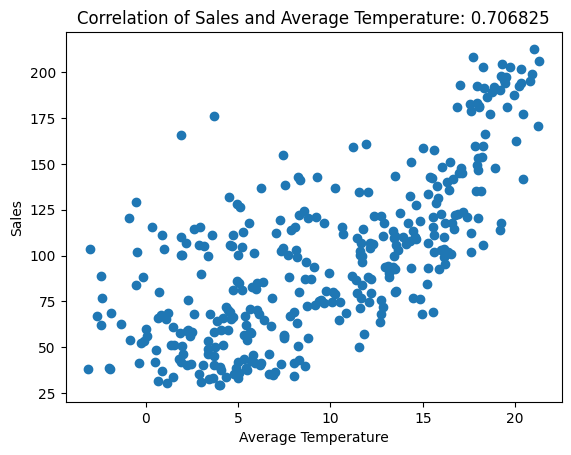

In [8]:
corr = sales_camping_wea['Umsatz'].corr(sales_camping_wea['TMK'])

plt.scatter(sales_camping_wea['TMK'], sales_camping_wea['Umsatz'])
plt.title(f'Correlation of Sales and Average Temperature: {round(corr,6)}')
plt.xlabel('Average Temperature')
plt.ylabel('Sales')
plt.show()

### Visualization

#### Comparision of Temperature and Sales over the years

In [9]:
# Visualization Correlation between Temperature and Sales
sales_camping_wea_vis = sales_camping_wea.copy()
sales_camping_wea_vis['year_month'] = sales_camping_wea_vis['year_month'].astype(str)

fig = px.line(sales_camping_wea_vis, x='year_month', y='TMK', title='Correlation between Temperature and Sales')
fig.add_scatter(x=sales_camping_wea_vis['year_month'], y=sales_camping_wea_vis['Umsatz'], mode='lines', yaxis='y2', name='Sales')

fig.update_layout(yaxis=dict(title='Temperatur (°C)'), yaxis2=dict(title='Umsatz', overlaying='y', side='right'))

fig.show()

#### Comparison of Temperature and Sales of the same month over the years


In [10]:
# Only data since 2010, as sales have stabilized since then
sales_camping_wea_2010 = sales_camping_wea[sales_camping_wea['Datum'].dt.year>=2010]

##### Analysis of the month August

In [11]:
# month August 
august_data = sales_camping_wea_2010[sales_camping_wea_2010['Datum'].dt.month == 8].copy()

average_tmk_august = august_data['TMK'].mean()
average_sales_august = august_data['Umsatz'].mean()

fig = px.scatter(august_data, x='TMK', y='Umsatz', color='TMK',
                 hover_data={'Year': august_data['Datum'].dt.year}, 
                 color_continuous_scale='RdBu_r', 
                 title='TMK vs Sales in August')

# Lines for average Temperaure and average Sales
tmk_line = pd.DataFrame({'TMK': [average_tmk_august, average_tmk_august],
                         'Sales': [august_data['Umsatz'].min(), august_data['Umsatz'].max()],
                         'Line': ['Average TMK'] * 2})
sales_line = pd.DataFrame({'TMK': [august_data['TMK'].min(), august_data['TMK'].max()],
                           'Sales': [average_sales_august, average_sales_august],
                           'Line': ['Average Sales'] * 2})

fig.add_scatter(x=tmk_line['TMK'], y=tmk_line['Sales'], mode='lines', name='Average TMK')
fig.add_scatter(x=sales_line['TMK'], y=sales_line['Sales'], mode='lines', name='Average Sales')

fig.update_traces(marker=dict(size=12, line=dict(width=2, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# fig.update_layout(
#     width=900,  
#     height=600,  
#)

fig.show()

In [12]:
# mean of Temperature and Sales of each month
monthly_mean_tmk = sales_camping_wea_2010.groupby(sales_camping_wea_2010['Datum'].dt.month)['TMK'].mean()
monthly_mean_sales = sales_camping_wea_2010.groupby(sales_camping_wea_2010['Datum'].dt.month)['Umsatz'].mean()

sales_camping_wea_2010['Month'] = sales_camping_wea_2010['Datum'].dt.month
sales_camping_wea_2010['TMK_Monthly_Mean'] = sales_camping_wea_2010['Month'].map(monthly_mean_tmk)

sales_camping_wea_2010['Sales_Monthly_Mean'] = sales_camping_wea_2010['Month'].map(monthly_mean_sales)


# Temperature and Sales Difference (in Comparison to the mean value) of each month
sales_camping_wea_2010['TMK_Diff'] = sales_camping_wea_2010['TMK'] - sales_camping_wea_2010['TMK_Monthly_Mean']
sales_camping_wea_2010['Sales_Diff'] = sales_camping_wea_2010['Umsatz'] - sales_camping_wea_2010['Sales_Monthly_Mean']

fig = px.scatter(sales_camping_wea_2010, x='TMK_Diff', y='Sales_Diff',
                 hover_data={'Year': sales_camping_wea_2010['Datum'].dt.year, 'Monat': sales_camping_wea_2010['Month']}, 
                 title='Temperaturedifference zum Mittelwert vs. Umsatzdifferenz zum Mittelwert von jedem Monat')

# Linie für den Gesamtmittelwert von TMK (bei TMK-Differenz = 0)
fig.add_hline(y=0, line_color="red", annotation_text="Gesamtmittel TMK", annotation_position="bottom right")

# Linie für den Gesamtmittelwert von Umsatz (bei Umsatz-Differenz = 0)
fig.add_vline(x=0, line_color="blue", annotation_text="Gesamtmittel Umsatz", annotation_position="top right")

fig.update_traces(marker=dict(size=5, line=dict(width=1, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

C:\Users\Ready2Go\AppData\Local\Temp\ipykernel_4340\830729103.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Ready2Go\AppData\Local\Temp\ipykernel_4340\830729103.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Ready2Go\AppData\Local\Temp\ipykernel_4340\830729103.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

The graphic is reminiscent of a division into true/false negatives/positives. If the temperature is below the average and so are sales (bottom left square) or the temperature is above the average and so are sales (top right square), we have true positives and negatives. If most of the data points lie in these two squares, our hypothesis that temperature has an influence is confirmed. This is the case here, as 9 points lie in the “true squares” and 4 do not. 

In order to look at more than just August, we can calculate the accuracy for each month, i.e. we calculate the proportion of true values compared to all values. In August, the Accuracy is 9/13 = 0.69, i.e. 70% of the sales seem to be influenced by the temperature.

##### Accuracy of every month

In [13]:
# empty DataFrame
accuracy_df = pd.DataFrame(columns=['Month', 'Accuracy'])

# Loop through all months
for month in range(1, 13):

    monthly_data = sales_camping_wea_2010[sales_camping_wea_2010['Datum'].dt.month == month].copy()

    # Average values for Temperature and Sales
    average_tmk_month = monthly_data['TMK'].mean()
    average_sales_month = monthly_data['Umsatz'].mean()

    # Count: Temperature and Sales are below/ above their average
    both_below_average = ((monthly_data['TMK'] < average_tmk_month) & (monthly_data['Umsatz'] < average_sales_month)).sum()
    both_above_average = ((monthly_data['TMK'] > average_tmk_month) & (monthly_data['Umsatz'] > average_sales_month)).sum()

    total_occurrences = len(monthly_data)

    accuracy = (both_below_average + both_above_average) / total_occurrences

    accuracy_df = pd.concat([accuracy_df, pd.DataFrame({'Month': [month], 'Accuracy': [accuracy]})], ignore_index=True)


fig = px.bar(accuracy_df, x='Month', y='Accuracy',
             title= 'Accuracy for each month')

fig.add_hline(y=0.5, line_dash="dash", line_color="black", annotation_text="Accuracy = 0.5",
              annotation_position="bottom right")

fig.show()

C:\Users\Ready2Go\AppData\Local\Temp\ipykernel_4340\3585356508.py:21: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [14]:
# Average Accuravy
avg_accuracy = accuracy_df.Accuracy.mean()
print(f'On average, the accuracy is {round(avg_accuracy, 4)}')

On average, the accuracy is 0.6245


You can see that for each month the influence of temperature on sales is different. In March and December the accuracy is below 50%, which means that apparently lower temperatures have an influence on good sales. 
In the other months, the Accuracy is >=50, in September it is even 0.846. Overall, it can be said that the temperature of a month has an influence on sales, but the influence is not particularly high, as the Accuracy is only 62.45% on average. But in the months of February, June, September and October, temperatures seem to have a relatively strong influence on sales.

##### Analysis of March and December

Question: Why is the accuarcy below 0.5 in march and december?

In [15]:
# month March 
march_data = sales_camping_wea_2010[sales_camping_wea_2010['Datum'].dt.month == 3].copy()

average_tmk_march = march_data['TMK'].mean()
average_sales_march = march_data['Umsatz'].mean()

fig = px.scatter(march_data, x='TMK', y='Umsatz', color='TMK',
                 hover_data={'Year': march_data['Datum'].dt.year}, 
                 color_continuous_scale='RdBu_r', 
                 title='TMK vs Sales in March')

# Lines for average Temperaure and average Sales
tmk_line = pd.DataFrame({'TMK': [average_tmk_march, average_tmk_march],
                         'Sales': [march_data['Umsatz'].min(), march_data['Umsatz'].max()],
                         'Line': ['Average TMK'] * 2})
sales_line = pd.DataFrame({'TMK': [march_data['TMK'].min(), march_data['TMK'].max()],
                           'Sales': [average_sales_march, average_sales_march],
                           'Line': ['Average Sales'] * 2})

fig.add_scatter(x=tmk_line['TMK'], y=tmk_line['Sales'], mode='lines', name='Average TMK')
fig.add_scatter(x=sales_line['TMK'], y=sales_line['Sales'], mode='lines', name='Average Sales')

fig.update_traces(marker=dict(size=12, line=dict(width=2, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

Explanation of why the Accuracy is below 0.5 in March and December: Both months have an “outlier”, an unusually low temperature value. If this outlier did not exist, the average temperature value would be higher and therefore there would also be more values in the “true fields”.